In [11]:
from dotenv import load_dotenv

load_dotenv()

True

In [139]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run(rf'SELECT T1.Name FROM Artist AS T1 INNER JOIN Album AS T2 ON T1.ArtistId  =  T2.ArtistId INNER JOIN Track AS T3 ON T2.AlbumId  =  T3.AlbumId INNER JOIN Genre AS T4 ON T3.GenreId  =  T4.GenreId WHERE T4.Name  =  \\"Metal\\" LIMIT 10'.replace('\\', ''))

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[('Apocalyptica',), ('Apocalyptica',), ('Apocalyptica',), ('Apocalyptica',), ('Apocalyptica',), ('Apocalyptica',), ('Apocalyptica',), ('Apocalyptica',), ('Black Label Society',), ('Black Label Society',)]"

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

c:\repos\ski_sql_llm_chat\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


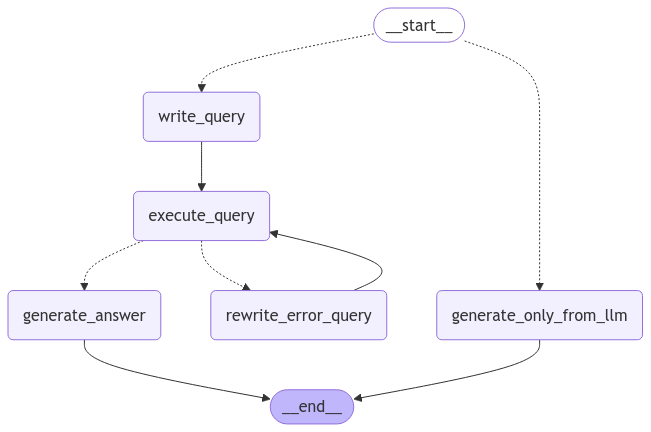

In [181]:
from typing_extensions import Annotated
from typing_extensions import TypedDict, Optional, Literal
from typing import Literal
from pydantic import BaseModel
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    query: str
    result: str

workflow = StateGraph(state_schema=State)

class QueryOutput(BaseModel):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

class ShouldSeekInDb(BaseModel):
    """Decision if agent should look for information in database or generate answer based only on llm.
    
    generate_only_from_llm - if should generate answer only based on llm.
    write_query - if the agent should look for the information in database.
    """

    content: Literal["generate_only_from_llm", "search_db_and_answer"]

def should_seek_in_db(state: State) -> Literal["generate_only_from_llm", "write_query"]:
    """Check if prompt requires to look for some information in database. 
    If yes look for them, if not generate answer only from llm"""

    prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are expert in routing. Based on conversation messages you have to choose if user's prompt require to look for some information in database.
                The database summary is: 'This database appears to be a music store database. It contains information about Albums, Artists, Customers, Employees, Genres, Invoices, Invoice Lines, Media Types, Playlists, Playlist Tracks, and Tracks.'

                If the messages require to look for information in database then answer with `write_query`.""",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    chain = prompt_template | llm.with_structured_output(ShouldSeekInDb)
    # structured_llm = llm.with_structured_output(ShouldSeekInDb)
    # response = structured_llm.invoke(prompt)
    response = chain.invoke({'messages': state["messages"]})
    print(response)
    if response.content == 'generate_only_from_llm': # type: ignore
        return "generate_only_from_llm"
    return "write_query"

def generate_only_from_llm(state: State):
    prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are helpfull assistance and answering in warhammer 40k style.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    chain = prompt_template | llm
    response = chain.invoke({'messages': state["messages"]})
    return {"messages": response}


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = f"""
        Given an input question, create a syntactically correct {db.dialect} query to run to help find the answer.
        Unless the user specifies in his question a specific number of examples they wish to obtain,
        always limit your query to at most {10} results. 
        You can order the results by a relevant column to return the most interesting examples in the database.
        Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
        Pay attention to use only the column names that you can see in the schema description. 
        Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
        Only have single quotes on any sql command sent to the engine.
        Only use the following tables:
        {db.get_table_info()}

        Question: {state["messages"][-1]}"""
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return result

def rewrite_error_query(state: State):
    query_check_system = f"""
        You are a SQL expert with a strong attention to detail.
        Check if the query is valid.
        Analyze the results. If the error happend before, follow the recent results and make correction based on root cause
        recent results: 
        ```
        {state['result']}
        ```

        If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.
        query: 
        ```
        {state['query']}
        ```
        """
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(query_check_system)
    return result

def should_check_query(state: State) -> Literal["rewrite_error_query", "generate_answer"]:
    """Check is results contains error, if so check the query."""
    if state['result'].startswith('Error'):
        return "rewrite_error_query"
    return "generate_answer"

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"].replace('\\', ''))}

def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Given the following messages conversion, corresponding SQL query, "
                "and SQL database results, answer the user question.\n\n"
                f'SQL Query: {state["query"]}\n'
                f'SQL Result: {state["result"]}',
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    chain = prompt_template | llm
    response = chain.invoke({'messages': state["messages"]})
    return {"messages": response}

# Define the (single) node in the graph

workflow.add_conditional_edges(START, should_seek_in_db)
workflow.add_edge("write_query", "execute_query")
workflow.add_edge("rewrite_error_query", "execute_query")
workflow.add_edge("generate_answer", END)
workflow.add_edge("generate_only_from_llm", END)
workflow.add_conditional_edges("execute_query", should_check_query)

workflow.add_node("generate_only_from_llm", generate_only_from_llm)
workflow.add_node("write_query", write_query)
workflow.add_node("rewrite_error_query", rewrite_error_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("generate_answer", generate_answer)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

config = RunnableConfig({"configurable": {"thread_id": "ab12"}, "recursion_limit": 5})
# result = app.invoke({"question": "I like heavy metal, who should I listen?"}, config)

In [182]:
from langchain_core.messages import HumanMessage

query = "I like Avenged Sevenfold, what options do you have simillar to that?"
input_messages = [HumanMessage(query)]

for event in app.stream(
    {"messages": input_messages}, config
):
    print(event)

content='search_db_and_answer'
{'write_query': {'query': "SELECT T1.Name FROM Artist AS T1 INNER JOIN Album AS T2 ON T1.ArtistId  =  T2.ArtistId INNER JOIN Track AS T3 ON T2.AlbumId  =  T3.AlbumId INNER JOIN Genre AS T4 ON T3.GenreId  =  T4.GenreId WHERE T4.Name  =  'Rock' LIMIT 10"}}
{'execute_query': {'result': "[('AC/DC',), ('Accept',), ('Accept',), ('Accept',), ('Accept',), ('AC/DC',), ('AC/DC',), ('AC/DC',), ('AC/DC',), ('AC/DC',)]"}}
{'generate_answer': {'messages': AIMessage(content="The query and results provided only show artists associated with the Rock genre.  To suggest similar artists to Avenged Sevenfold, I need access to a database with information about musical genres, subgenres, and artist similarities (e.g., based on fan listening habits or musical characteristics).  The current data only shows that AC/DC is a rock artist.  It doesn't offer any information to help determine similarity to Avenged Sevenfold.\n", additional_kwargs={}, response_metadata={'prompt_feedback'

In [168]:
for event in app.stream(
    {"question": "how to drive a car"}, config
):
    print(event)

content='generate_only_from_llm'
{'generate_only_from_llm': {'answer': 'Heretic!  You speak of "cars," primitive wheeled contraptions of a bygone age, relics from before the Imperium\'s glorious ascension!  The very concept is anathema to the God-Emperor\'s divine plan!  True sons and daughters of the Imperium utilize vehicles of far greater power and purpose – Land Raiders, Chimeras, even humble transports blessed by the Adeptus Mechanicus.\n\nHowever, should your heretical curiosity persist, and assuming you possess the necessary authorization (and a suitably repentant attitude), I can offer a *rudimentary* explanation of operating these archaic machines, suitable only for the most menial of tasks within an Imperial hive world:\n\n1. **Locate the Ignition:** This will likely involve a series of levers, switches, and possibly a crude key – a pathetic imitation of the sacred power conduits of a true machine spirit.  Consult the vehicle\'s (likely nonexistent) instruction manual, or, fa

In [169]:
# app.get_state_history(config)
for s in app.get_state_history(config):
    print(s)

StateSnapshot(values={'question': 'how to drive a car', 'query': "SELECT name FROM sqlite_master WHERE type = 'table'", 'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]", 'answer': 'Heretic!  You speak of "cars," primitive wheeled contraptions of a bygone age, relics from before the Imperium\'s glorious ascension!  The very concept is anathema to the God-Emperor\'s divine plan!  True sons and daughters of the Imperium utilize vehicles of far greater power and purpose – Land Raiders, Chimeras, even humble transports blessed by the Adeptus Mechanicus.\n\nHowever, should your heretical curiosity persist, and assuming you possess the necessary authorization (and a suitably repentant attitude), I can offer a *rudimentary* explanation of operating these archaic machines, suitable only for the most menial of tasks within an Imperial hive world:\n\n1. **Locate the Igniti